In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fclusterdata
from sklearn.cluster import Birch
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Predicting Genre with Song Characteristics

Let's see if we are able to predict the genres of songs in our dataset using the different audio features of tracks that were identified by Spotify, like "loudness" or "danceability."

We'll start by importing our .csv data into pandas. We can drop popularity for now, which has only been collected for a small number of our datapoints.

In [2]:
tracks = pd.read_csv('data/audio_features_4.0_clean.csv')
tracks = tracks.drop(['popularity'], axis=1)

seed = 538

In [3]:
# Prototyping sample for model selection
tracks = tracks.sample(n=25000, random_state=seed)

## Initial visualization

We'll perform some initial visualizations to get a better sense of our data.

So that we can see the coorelation with genre, we'll encode genre with label encoder.

In [4]:
# Encode genre with label encoder.
label_enc = LabelEncoder()
tracks_enc = tracks.copy(deep=True)
tracks_enc.loc[:, 'genre'] = label_enc.fit_transform(tracks.genre)

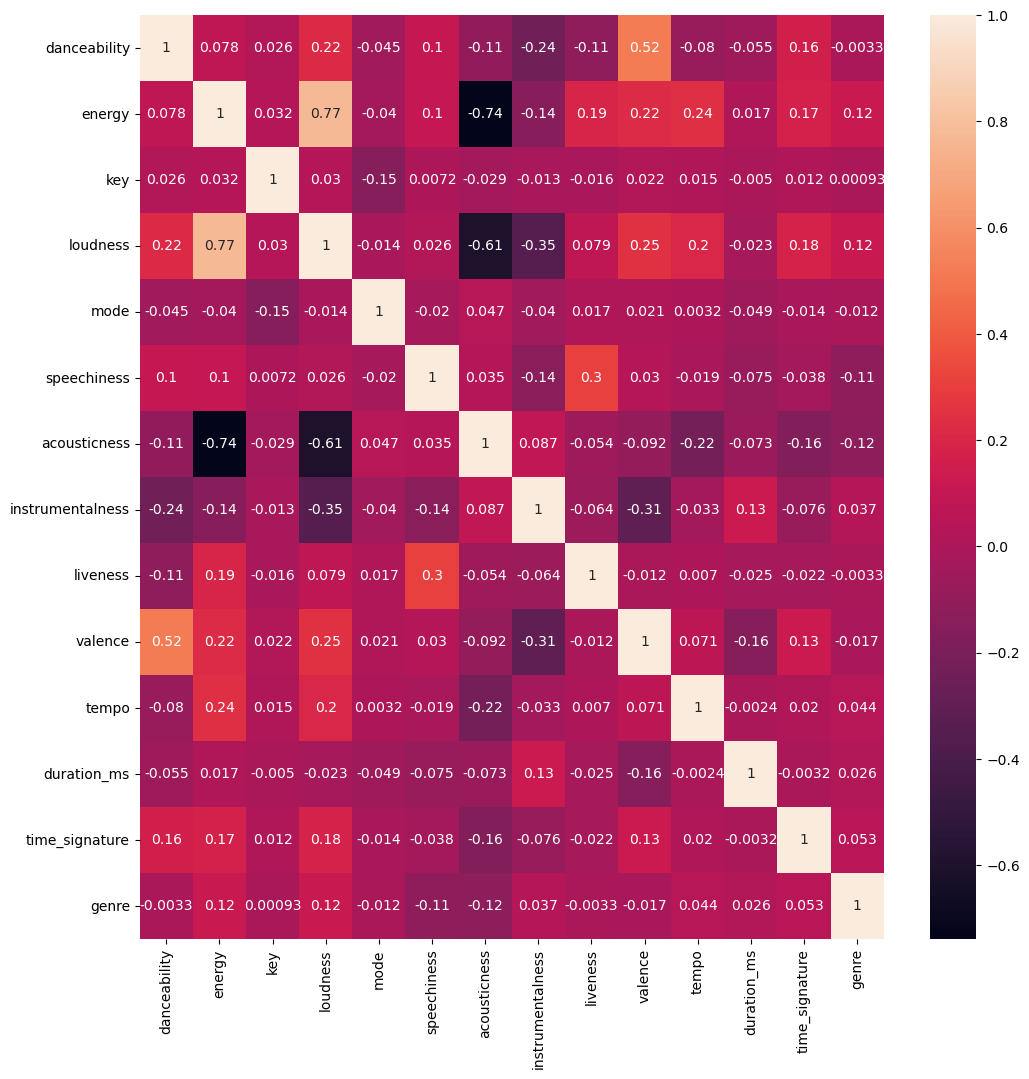

In [5]:
# Coorelation matrix heatmap.
fig = plt.figure(figsize=(12, 12))
sns.heatmap(tracks_enc.corr(), annot=True)
plt.show()

Overall, there is high colinearity between some features (like loudness and energy), but only a moderate relationship between our different predictors and genre. This will make our classification task more difficult.

Let's also check the distribution of our features.

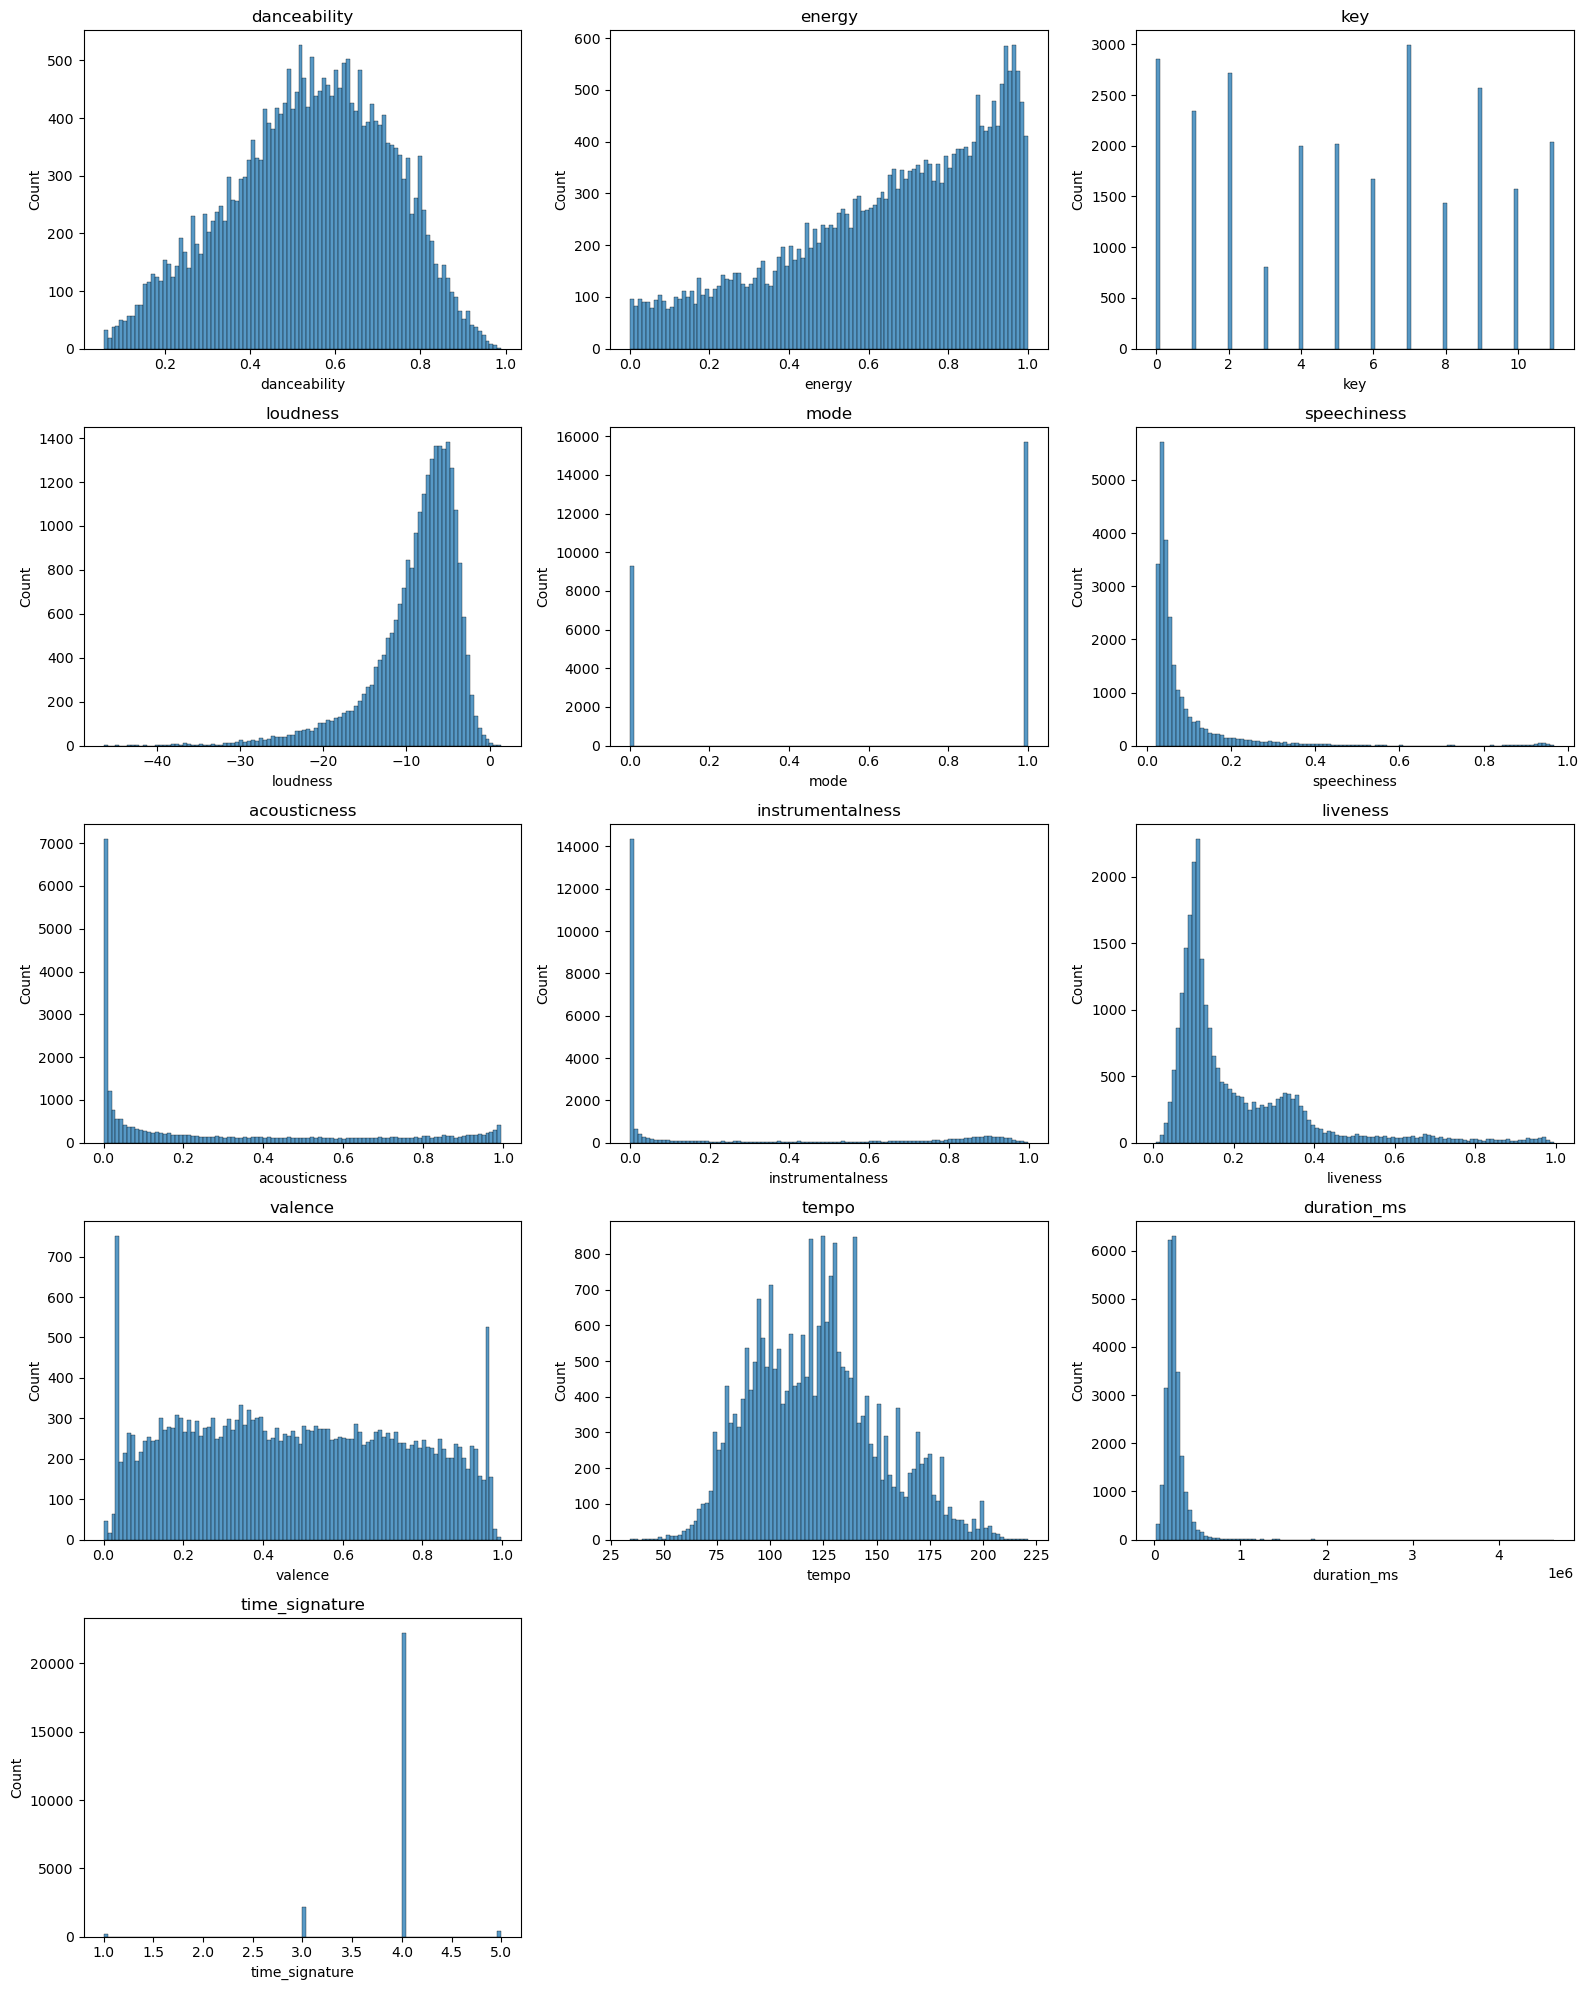

In [6]:
cols = tracks.select_dtypes(include={'int64', 'float64'}).columns
ncols = 3

nrows = (len(cols) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, 
                         ncols=ncols, 
                         figsize=(16, 4 * nrows), 
                         sharey=False)
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.histplot(tracks, x=col, bins=100, ax=axes[i])
    axes[i].set_title(col)

for i in range(len(cols), nrows * ncols):
    fig.delaxes(axes[i])

fig.tight_layout()
plt.show()

Based on these plots, we can see that energy, loudness, and liveness are moderately skewed. Speechiness, acousticness, and instrumentalness are even more skewed. Valence is roughly uniformly distributed, with some clustering at both extremes.

Because some of our features are skewed and not normally-distributed, we'll have to use techniques that are robust to these distributions. Furthermore, we should keep in mind that, as we established in the previous data cleaning notebook, some of our features have significant numbers of outliers.

Let's also look at class imbalance, which is another important consideration when modeling.

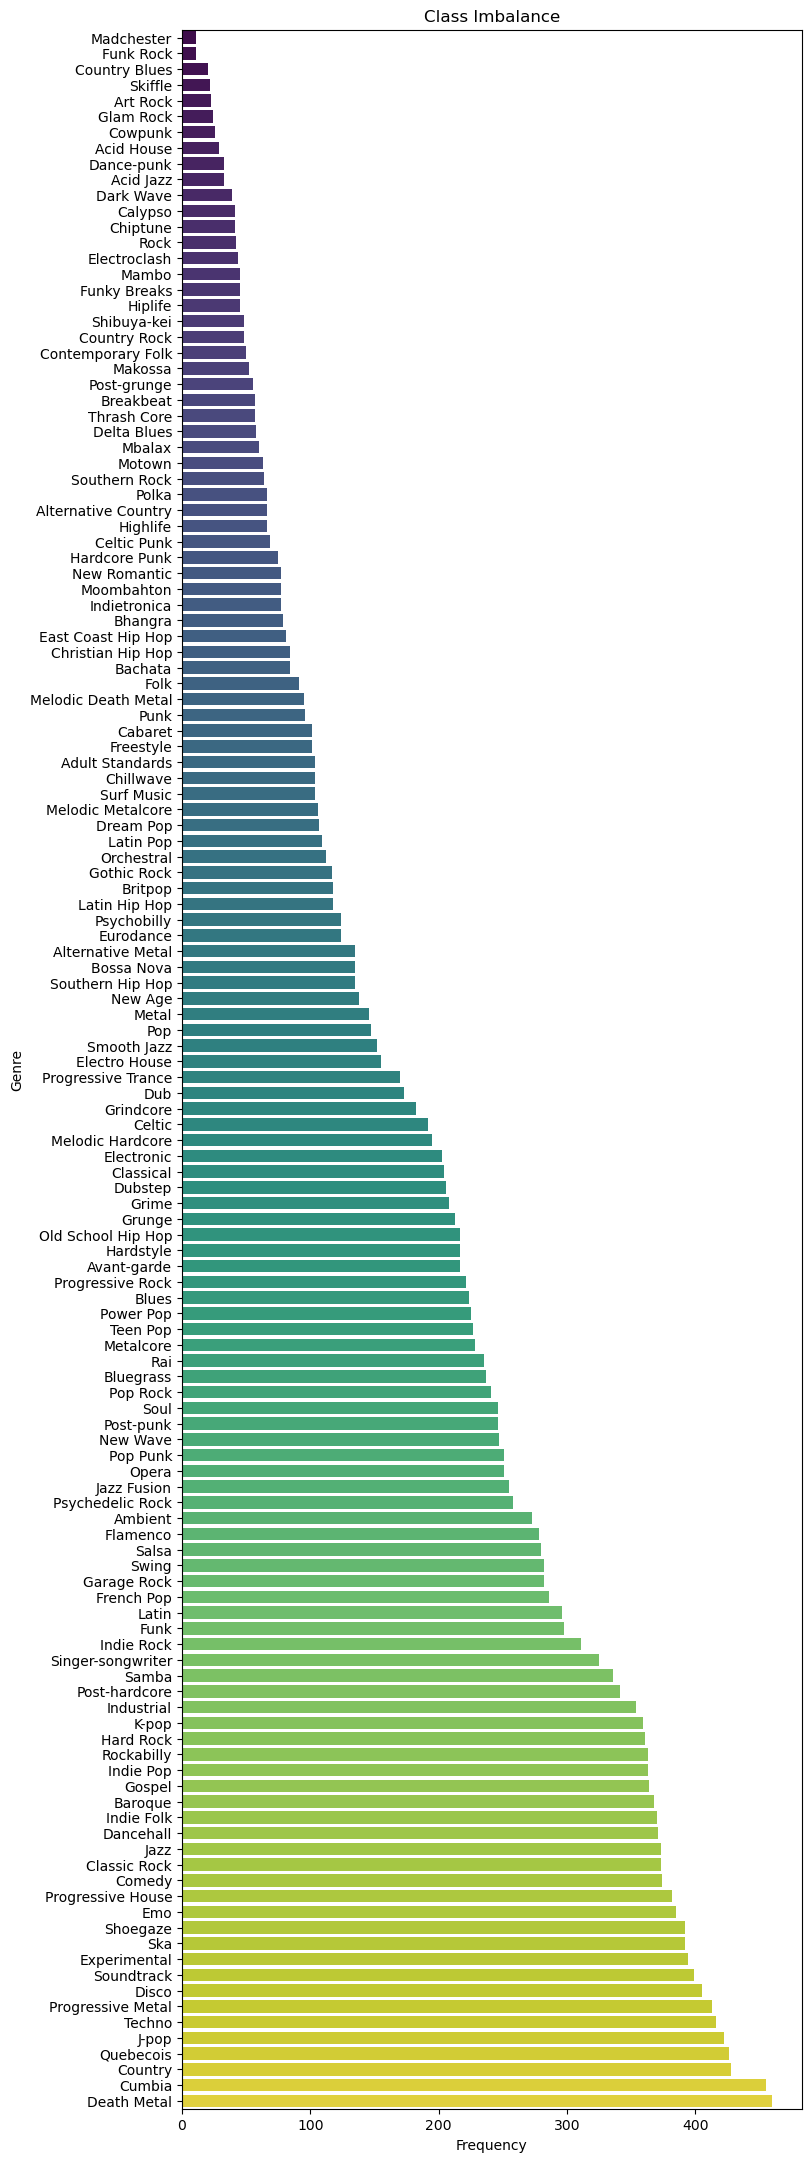

In [7]:
class_counts = tracks['genre'].value_counts() \
                            .sort_values(ascending=True)

plt.figure(figsize=(8, 27))
sns.barplot(x=class_counts.values, 
            y=class_counts.index, 
            orient='h', 
            palette='viridis')
plt.xlabel('Frequency')
plt.ylabel('Genre')
plt.title('Class Imbalance')
plt.show()

## Class balancing, scaling, and train-test split

For now, we'll remove classes from our dataset with fewer than 1000 datapoints.

In [8]:
genre_counts = tracks.groupby(by='genre').size()
filtered_genres = genre_counts[genre_counts > 50].index
tracks = tracks[tracks.genre.isin(filtered_genres)]

Let's split our data into train and test so we can start building an initial classification model as a baseline.

For our initial model, we'll drop non-numeric features.

In [9]:
# Drop genre, our target, as well as the columns with text data 
# and the Spotify track id.
X = tracks.drop(['genre', 
                 'song_name',
                 'artist_name',
                 'spotify_track_id'], axis=1)
y = tracks.genre
y = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.3, 
                                                    random_state=seed)

 Now, we will use SMOTE over-sampling to randomly generate new datapoints for the remaining under-represented classes, with the new random points being based on the existing data in those classes.

In [10]:
over_sampler = SMOTE()
X_train_smote, y_train_smote = over_sampler.fit_resample(X_train, y_train)

## Initial modeling

Let's start with K-Nearest Neighbors as a baseline to see what kind of accuracy we can achieve.

We found a high number of outliers in our previous data cleaning analysis, which seem simply to be extreme values rather than bad data. Some of the features are also highly skewed.

To help mitigate these complexities we will start with RobustScaler, which is good at handling outliers and skew. If our features had very different scales RobustScaler might not perform well, but in our case the values are mostly close, with the exception of duration_ms, so it seems like a reasonable choice.

In [11]:
scaler = RobustScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

To get a baseline, we'll train a K-Nearest Neighbors classifier.

In [12]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_smote_scaled, y_train_smote)
knn_model.score(X_test_scaled, y_test)

0.09527732015376167

An accuracy of only 14% tells us that we have a lot of work to do. Before we test additional models and hyperparameters, let's see if the high number of classes in our dataset (over 100 genres) and the class imbalance is impacting performance, and whether that issue can be mitigated.

STRIKE: Class aggregation using hierarchical clustering

In [13]:
# from scipy.cluster.hierarchy import set_link_color_palette

# tracks_data = tracks.drop(['artist_name', 'song_name', 'spotify_track_id'], axis=1)

# agg_tracks = tracks_data.groupby('genre').agg(['mean', 'std', lambda x: x.skew(), lambda x: x.kurt()])

# agg_tracks.columns = ['_'.join(col).strip() for col in agg_tracks.columns.values]

# agg_tracks.reset_index(inplace=True)

# data_matrix = agg_tracks.drop(columns=['genre'], axis=1).to_numpy()
# class_labels = agg_tracks['genre'].tolist()

# # Perform hierarchical clustering
# linked = linkage(data_matrix, method='ward', metric='euclidean')

# set_link_color_palette(['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'])

# cut_height = 15000 

# plt.figure(figsize=(10, 30), dpi=600)
# dendrogram(linked, 
#            labels=class_labels, 
#            orientation='right', 
#            distance_sort='descending', 
#            show_leaf_counts=True,
#            color_threshold=cut_height)  # Set the color_threshold parameter to cut_height

# plt.axvline(x=cut_height, color='r', linestyle='--')

# plt.xlabel('Distance')
# plt.ylabel('Genres')
# plt.title('Hierarchical Clustering Dendrogram')
# plt.show()

## Classification with alternative scoring

One reason why it might be difficult to classify genres accurately is that there are some very similar genres in our dataset. For example, we have many different sub-genres of Hip Hop, rock, etc. 

One way we can address this is to relax the rules for classification, so that it counts as an accurate prediction if any of the top three options identified by the model are the correct genre. 

We can implement this with a custom scoring function. We'll also create a version that scores the top 2 and 4 results so we can compare.

In [14]:
def top_3_accuracy(y_true, y_pred_proba):
    top_classes = np.argsort(y_pred_proba, axis=1)[:, -3:]
    matches = [y_true[i] in top_classes[i] for i in range(len(y_true))]
    return np.mean(matches)

def top_2_accuracy(y_true, y_pred_proba):
    top_classes = np.argsort(y_pred_proba, axis=1)[:, -2:]
    matches = [y_true[i] in top_classes[i] for i in range(len(y_true))]
    return np.mean(matches)

def top_4_accuracy(y_true, y_pred_proba):
    top_classes = np.argsort(y_pred_proba, axis=1)[:, -4:]
    matches = [y_true[i] in top_classes[i] for i in range(len(y_true))]
    return np.mean(matches)

top_3_scorer = make_scorer(top_3_accuracy, needs_proba=True)

Let's go back to KNN, and see what result we get with our custom scorer.

In [15]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_smote_scaled, y_train_smote)
y_pred_proba = knn_model.predict_proba(X_test_scaled)

print('Top 2:', top_2_accuracy(y_test, y_pred_proba))
print('Top 3:', top_3_accuracy(y_test, y_pred_proba))
print('Top 4:', top_4_accuracy(y_test, y_pred_proba))

Top 2: 0.15595826468973092
Top 3: 0.20400878638110928
Top 4: 0.22940691927512355


The lower bar for classification success has improved our results somewhat. Now let's go through and test a variety of models to see what level of success we can achieve.

## K-Nearest Neighbors Classifier

Let's try out a variety of k values, performing 5-fold cross-validation on each to find the best result.

In [16]:
# 2.5 mins to run

k_values = list(range(2, 21))
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, 
                            X_train_smote_scaled, 
                            y_train_smote, 
                            scoring=top_3_scorer, 
                            cv=5) \
                            .mean()
    scores.append(score)

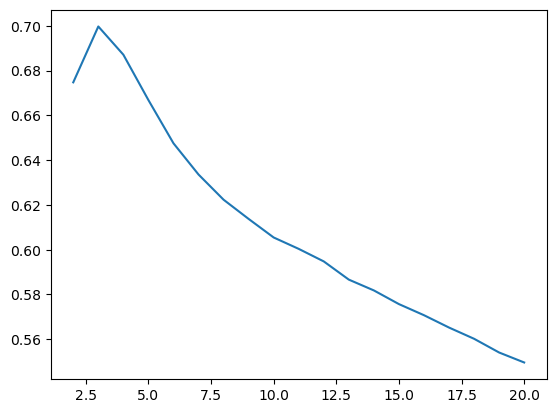

In [17]:
plt.plot(k_values, scores)
plt.show()

Overall, it seems that performance drops rapidly with higher values of k.

In [26]:
# Get the index of the best score and lookup the best k.
best_k = k_values[np.argmax(scores)]
best_score = np.max(scores)

knn_best_k = KNeighborsClassifier(n_neighbors=best_k)
knn_best_k.fit(X_train_smote_scaled, y_train_smote)
y_pred_proba = knn_best_k.predict_proba(X_test_scaled)

print('Top 2:', top_2_accuracy(y_test, y_pred_proba))
print('Top 3:', top_3_accuracy(y_test, y_pred_proba))
print('Top 4:', top_4_accuracy(y_test, y_pred_proba))

Top 2: 0.150054914881933
Top 3: 0.17462932454695224
Top 4: 0.1825919824272378


This result indicates that KNN is likely not the best approach. Not only does the value for k obtained through cross-validation result in a slightly worse score than the default value of 5, but also there is a huge discreprepancy between train and test, which likely means we are overfitting.

## Logistic Regression CV

In [39]:
# 4 minutes to run.
regressor = LogisticRegressionCV(max_iter=10000, 
                                 cv=5, 
                                 random_state=seed,
                                 scoring=top_3_scorer) \
                                .fit(X_train_smote_scaled, y_train_smote)

y_lr_probas = regressor.predict_proba(X_test_scaled)
print('Top 2:', top_2_accuracy(y_test, y_lr_probas))
print('Top 3:', top_3_accuracy(y_test, y_lr_probas))
print('Top 4:', top_4_accuracy(y_test, y_lr_probas))

# Results are getting better!
# Top 2: 0.22116968698517298
# Top 3: 0.2802031850631521
# Top 4: 0.33360790774299837

Top 2: 0.22116968698517298
Top 3: 0.2802031850631521
Top 4: 0.33360790774299837


## Random Forest Classifier

In [ ]:
params = {  
    "n_estimators": list(range(20, 221, 50)),
    "max_depth": list(range(10, 101, 10)),

    # Check 1 feature, all the features, and midway in-between
    "max_features": list(range(1, len(X_train.columns), 5))
    }

forest_grid = GridSearchCV(RandomForestClassifier(random_state=seed), 
                           param_grid=params, 
                           scoring=top_3_scorer) \
                           .fit(X_train_smote_scaled, y_train)

## Visualization

In [16]:
# tracks_sample = tracks
# genre_counts = tracks_sample.groupby(by='genre').size()
# print(len(tracks_sample.genre.unique()))
# print(len(genre_counts[genre_counts > 1000].index))
# tracks_sample = tracks_sample[tracks_sample.genre.isin(genre_counts[genre_counts > 100].index)]
# # tracks_sample = tracks

# X = tracks_sample.drop(['song_name', 
#                         'artist_name', 
#                         'spotify_track_id',
#                         'genre'], 
#                        axis=1)
# X = RobustScaler().fit_transform(X, y)
# y = tracks_sample.genre
# y = LabelEncoder().fit_transform(y)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=538)
# X_train_smote, y_train_smote = SMOTE().fit_resample(X_train, y_train)

# # 20K: .36, 4 minutes
# model = xgb.XGBClassifier(eval_metric='mlogloss',
#                           max_depth=50,
#                           n_estimators=250)
# model.fit(X_train_smote, y_train_smote)

# y_pred_proba = model.predict_proba(X_test)
# # y_pred = knn.predict(X_test)

# # print('Y_pred_proba:', y_pred_proba.tolist())
# # print('y_pred      :', y_pred.tolist())
# # print('y_true      :', y_test.tolist())

# # print(accuracy_score(y_test, y_pred))
# print(top_3_accuracy(y_test, y_pred_proba))

STRIKE: Clustering


In [17]:
# tracks_numeric = tracks.select_dtypes(['float64', 'int64'])
# tracks_no_pop = tracks_numeric.drop(labels=['popularity'], axis=1)

In [18]:
# scaler = RobustScaler()
# numeric_features_scaled = scaler.fit_transform(tracks_no_pop)

Use the elbow method to find the optimal amount of clusters.

In [19]:
# inertia_values: List[float] = []
# K_RANGE = range(1, 31)

# for k in K_RANGE:
#     model = KMeans(n_clusters=k, 
#                    random_state=538, 
#                    n_init=10)
#     model.fit(numeric_features_scaled)
#     inertia_values.append(model.inertia_)
#     print('Finished checking k =', k)

In [20]:
# plt.plot(K_RANGE, inertia_values)
# plt.title('K against Within-Cluster Sum of Squares')
# plt.ylabel('Within-Cluster Sum of Squares')
# plt.xlabel('K value')
# plt.show()

The curve doesn't seem to level out until k = 17 based on the elbow method.

In [21]:
# BEST_K = 17

In [22]:
# kmeans_model = KMeans(n_clusters=BEST_K, 
#                       random_state=538, 
#                       n_init=10)
# clusters = kmeans_model.fit_predict(numeric_features_scaled)

In [23]:
# tracks['cluster'] = clusters

In [24]:
# for cluster in range(BEST_K + 1)[0:1]:
#     tracks_filtered = tracks[tracks.cluster == cluster]
#     print('Cluster:', 
#           cluster, 
#           tracks_filtered.sample(10))